# 🎨 Data Designer Tutorial: Providing Images as Context for Vision-Based Data Generation

#### 📚 What you'll learn

This notebook demonstrates how to provide images as context to generate text descriptions using vision-language models.

- ✨ **Visual Document Processing**: Converting images to chat-ready format for model consumption
- 🔍 **Vision-Language Generation**: Using vision models to generate detailed summaries from images

If this is your first time using Data Designer, we recommend starting with the [first notebook](/notebooks/1-the-basics/) in this tutorial series.


### ⬇️ Install dependencies (if required)

In [1]:
!uv pip install pillow

Using Python 3.11.14 environment at: /home/runner/work/DataDesigner/DataDesigner/.venv
⠙ Resolving dependencies...                                                     

⠙ pillow==12.0.0                                                                

Resolved 1 package in 74ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
pillow               ------------------------------ 16.00 KiB/6.71 MiB          

⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
pillow               ------------------------------ 272.00 KiB/6.71 MiB         

⠙ Preparing packages... (0/1)
pillow               ------------------------------ 1.09 MiB/6.71 MiB           

⠙ Preparing packages... (0/1)
Prepared 1 package in 178ms
░░░░░░░░░░░░░░░░░░░░ [0/1] Installing wheels...                                 

Installed 1 package in 4ms
 + pillow==12.0.0


### 📦 Import the essentials

- The `essentials` module provides quick access to the most commonly used objects.


In [2]:
# Standard library imports
import base64
import io
import uuid

# Third-party imports
import pandas as pd
import rich
from datasets import load_dataset
from IPython.display import display
from rich.panel import Panel

# Data Designer imports
from data_designer.essentials import (
    DataDesigner,
    DataDesignerConfigBuilder,
    ImageContext,
    ImageFormat,
    InferenceParameters,
    LLMTextColumnConfig,
    ModalityDataType,
    ModelConfig,
)

### ⚙️ Initialize the Data Designer interface

- `DataDesigner` is the main object is responsible for managing the data generation process.

- When initialized without arguments, the [default model providers](https://nvidia-nemo.github.io/DataDesigner/concepts/models/default-model-settings/) are used.


In [3]:
data_designer = DataDesigner()

### 🎛️ Define model configurations

- Each `ModelConfig` defines a model that can be used during the generation process.

- The "model alias" is used to reference the model in the Data Designer config (as we will see below).

- The "model provider" is the external service that hosts the model (see the [model config](https://nvidia-nemo.github.io/DataDesigner/concepts/models/default-model-settings/) docs for more details).

- By default, we use [build.nvidia.com](https://build.nvidia.com/models) as the model provider.


In [4]:
# This name is set in the model provider configuration.
MODEL_PROVIDER = "nvidia"

model_configs = [
    ModelConfig(
        alias="vision",
        model="meta/llama-4-scout-17b-16e-instruct",
        provider=MODEL_PROVIDER,
        inference_parameters=InferenceParameters(
            temperature=0.60,
            top_p=0.95,
            max_tokens=2048,
        ),
    ),
]

### 🏗️ Initialize the Data Designer Config Builder

- The Data Designer config defines the dataset schema and generation process.

- The config builder provides an intuitive interface for building this configuration.

- The list of model configs is provided to the builder at initialization.


In [5]:
config_builder = DataDesignerConfigBuilder(model_configs=model_configs)

### 🌱 Seed Dataset Creation

In this section, we'll prepare our visual documents as a seed dataset for summarization:

- **Loading Visual Documents**: We use the ColPali dataset containing document images
- **Image Processing**: Convert images to base64 format for vision model consumption
- **Metadata Extraction**: Preserve relevant document information (filename, page number, source, etc.)

The seed dataset will be used to generate detailed text summaries of each document image.

In [6]:
# Dataset processing configuration
IMG_COUNT = 512  # Number of images to process
BASE64_IMAGE_HEIGHT = 512  # Standardized height for model input

# Load ColPali dataset for visual documents
img_dataset_cfg = {"path": "vidore/colpali_train_set", "split": "train", "streaming": True}

In [7]:
def resize_image(image, height: int):
    """
    Resize image while maintaining aspect ratio.

    Args:
        image: PIL Image object
        height: Target height in pixels

    Returns:
        Resized PIL Image object
    """
    original_width, original_height = image.size
    width = int(original_width * (height / original_height))
    return image.resize((width, height))


def convert_image_to_chat_format(record, height: int) -> dict:
    """
    Convert PIL image to base64 format for chat template usage.

    Args:
        record: Dataset record containing image and metadata
        height: Target height for image resizing

    Returns:
        Updated record with base64_image and uuid fields
    """
    # Resize image for consistent processing
    image = resize_image(record["image"], height)

    # Convert to base64 string
    img_buffer = io.BytesIO()
    image.save(img_buffer, format="PNG")
    byte_data = img_buffer.getvalue()
    base64_encoded_data = base64.b64encode(byte_data)
    base64_string = base64_encoded_data.decode("utf-8")

    # Return updated record
    return record | {"base64_image": base64_string, "uuid": str(uuid.uuid4())}

In [8]:
# Load and process the visual document dataset
print("📥 Loading and processing document images...")

img_dataset_iter = iter(
    load_dataset(**img_dataset_cfg).map(convert_image_to_chat_format, fn_kwargs={"height": BASE64_IMAGE_HEIGHT})
)
img_dataset = pd.DataFrame([next(img_dataset_iter) for _ in range(IMG_COUNT)])

print(f"✅ Loaded {len(img_dataset)} images with columns: {list(img_dataset.columns)}")

📥 Loading and processing document images...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/82 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/82 [00:00<?, ?it/s]

✅ Loaded 512 images with columns: ['image', 'image_filename', 'query', 'answer', 'source', 'options', 'page', 'model', 'prompt', 'answer_type', 'base64_image', 'uuid']


In [9]:
img_dataset.head()

,image,image_filename,query,answer,source,options,page,model,prompt,answer_type,base64_image,uuid
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,images/1810.07757_2.jpg,"Comparing panels a, b, c, and d, which stateme...",D,arxiv_qa,['A. The variance of the data decreases from p...,,gpt4V,,None,iVBORw0KGgoAAAANSUhEUgAAAUAAAAIACAIAAAB8QiIMAA...,d50a8fed-5737-4da0-85ba-bae7b33fc8f0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,data/scrapped_pdfs_split/pages_extracted/energ...,What is the duration of the course mentioned i...,"['five to ten hours, not including field trips']",pdf,None,9,sonnet,\n You are an assistant specialized in ...,None,iVBORw0KGgoAAAANSUhEUgAAAYsAAAIACAIAAAD8HddaAA...,688fccf8-0099-4aac-8a75-4ac54c311efe
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,data/scrapped_pdfs_split/pages_extracted/energ...,What is the primary purpose of the PTC in lith...,['protect against external short circuits'],pdf,None,414,sonnet,\n You are an assistant specialized in ...,None,iVBORw0KGgoAAAANSUhEUgAAAZgAAAIACAIAAAAwhO2xAA...,bf2b8ed1-25a7-4d79-98f1-ca76fc4d9e5b
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0fd47b51ae9248ef36669b8619b1223f268edae3e7a44a...,What is the date?\nYour answer should be very ...,"OCTOBER 17, 1995.",docvqa,None,None,None,None,None,iVBORw0KGgoAAAANSUhEUgAAAX0AAAIACAAAAABLRuMPAA...,4a84c710-33ec-46fa-85ea-9ef75381ec6e
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,b335cfb9d442f8925ea41a064cb445a5395577f2345d52...,What is Bert Shulimson's title?\nYour response...,EXECUTIVE SECRETARY.,docvqa,None,None,None,None,None,iVBORw0KGgoAAAANSUhEUgAAAY8AAAIACAAAAABf/7+rAA...,09131c68-14e8-4b43-bd43-52158330a1d8


In [10]:
# Add the seed dataset containing our processed images
df_seed = pd.DataFrame(img_dataset)[["uuid", "image_filename", "base64_image", "page", "options", "source"]]
config_builder.with_seed_dataset(
    DataDesigner.make_seed_reference_from_dataframe(df_seed, file_path="colpali_train_set.csv")
)

[16:20:18] [INFO] 💾 Saving seed dataset to colpali_train_set.csv


DataDesignerConfigBuilder(
    seed_dataset: 'colpali_train_set.csv'
    seed_dataset_columns: [
        "uuid",
        "image_filename",
        "base64_image",
        "page",
        "options",
        "source"
    ]
)

In [11]:
# Add a column to generate detailed document summaries
config_builder.add_column(
    LLMTextColumnConfig(
        name="summary",
        model_alias="vision",
        prompt=(
            "Provide a detailed summary of the content in this image in Markdown format. "
            "Start from the top of the image and then describe it from top to bottom. "
            "Place a summary at the bottom."
        ),
        multi_modal_context=[
            ImageContext(
                column_name="base64_image",
                data_type=ModalityDataType.BASE64,
                image_format=ImageFormat.PNG,
            )
        ],
    )
)

DataDesignerConfigBuilder(
    seed_dataset: 'colpali_train_set.csv'
    seed_dataset_columns: [
        "uuid",
        "image_filename",
        "base64_image",
        "page",
        "options",
        "source"
    ]
    llm_text_columns: ['summary']
)

### 🔁 Iteration is key – preview the dataset!

1. Use the `preview` method to generate a sample of records quickly.

2. Inspect the results for quality and format issues.

3. Adjust column configurations, prompts, or parameters as needed.

4. Re-run the preview until satisfied.


In [12]:
preview = data_designer.preview(config_builder, num_records=2)

[16:20:19] [INFO] 🕵️ Preview generation in progress


[16:20:19] [INFO] ✅ Validation passed


[16:20:19] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph


[16:20:19] [INFO] 🩺 Running health checks for models...


[16:20:19] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct' in provider named 'nvidia' for model alias 'vision'...


[16:20:20] [INFO]   |-- ✅ Passed!


[16:20:24] [INFO] 🌱 Sampling 2 records from seed dataset


[16:20:24] [INFO]   |-- seed dataset size: 512 records


[16:20:24] [INFO]   |-- sampling strategy: ordered


[16:20:24] [INFO] 📝 Preparing llm-text column generation


[16:20:24] [INFO]   |-- column name: 'summary'


[16:20:24] [INFO]   |-- model config:
{
    "alias": "vision",
    "model": "meta/llama-4-scout-17b-16e-instruct",
    "inference_parameters": {
        "temperature": 0.6,
        "top_p": 0.95,
        "max_tokens": 2048,
        "max_parallel_requests": 4,
        "timeout": null,
        "extra_body": null
    },
    "provider": "nvidia"
}


[16:20:24] [INFO] 🐙 Processing llm-text column 'summary' with 4 concurrent workers


[16:20:29] [INFO] 📊 Model usage summary:
{
    "meta/llama-4-scout-17b-16e-instruct": {
        "token_usage": {
            "prompt_tokens": 1396,
            "completion_tokens": 743,
            "total_tokens": 2139
        },
        "request_usage": {
            "successful_requests": 2,
            "failed_requests": 0,
            "total_requests": 2
        },
        "tokens_per_second": 278,
        "requests_per_minute": 15
    }
}


[16:20:29] [INFO] 📐 Measuring dataset column statistics:


[16:20:29] [INFO]   |-- 🌱 column: 'uuid'


[16:20:29] [INFO]   |-- 🌱 column: 'image_filename'


[16:20:29] [INFO]   |-- 🌱 column: 'base64_image'


[16:20:29] [INFO]   |-- 🌱 column: 'page'


[16:20:29] [INFO]   |-- 🌱 column: 'options'


[16:20:29] [INFO]   |-- 🌱 column: 'source'


[16:20:29] [INFO]   |-- 📝 column: 'summary'


[16:20:29] [INFO] 🏆 Preview complete!


In [13]:
# Run this cell multiple times to cycle through the 2 preview records.
preview.display_sample_record()

                                                   Seed Columns                                                    
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name           ┃ Value                                                                                          ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ uuid           │ d50a8fed-5737-4da0-85ba-bae7b33fc8f0                                                           │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ image_filename │ images/1810.07757_2.jpg                                                                        │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ base64_image   │ iVBORw0KGgoAAAANSUhEUgAAAUAAAAIACAIAAAB8QiIMAAEAAElEQVR4nOy9edRt2VUX+vvNufY+53zNbauvVJdKSEUQQ… │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ page           │ nan                                                                                            │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ options        │ ['A. The variance of the data decreases from panel a to panel d.', 'B. The variance of the     │
│                │ data increases from panel a to panel d.', 'C. The data presents no variance in any of the      │
│                │ panels.', 'D. The variance of the data is inconsistent across the panels.', '-']               │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ source         │ arxiv_qa                                                                                       │
└────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘
                                                                                                                   
                                                                                                                   
                                                 Generated Columns                                                 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name    ┃ Value                                                                                                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ summary │ ## Image Summary                                                                                      │
│         │                                                                                                       │
│         │ The image presents a collection of 8 heatmap graphs, arranged in two columns of four rows each. The   │
│         │ graphs are labeled from "a)" to "h)".                                                                 │
│         │                                                                                                       │
│         │ ### Top Section: Color Bar                                                                            │
│         │                                                                                                       │
│         │ * A color bar is provided at the top, representing a correlation coefficient (τ) ranging from 0.2 to  │
│         │ 1.                                                                                                    │
│         │ * The color bar transitions from dark blue (0.2) to yellow (1).                                       │
│         │                                             

In [14]:
# The preview dataset is available as a pandas DataFrame.
preview.dataset

,uuid,image_filename,base64_image,page,options,source,summary
0,d50a8fed-5737-4da0-85ba-bae7b33fc8f0,images/1810.07757_2.jpg,iVBORw0KGgoAAAANSUhEUgAAAUAAAAIACAIAAAB8QiIMAA...,NaN,['A. The variance of the data decreases from p...,arxiv_qa,## Image Summary\n\nThe image presents a colle...
1,688fccf8-0099-4aac-8a75-4ac54c311efe,data/scrapped_pdfs_split/pages_extracted/energ...,iVBORw0KGgoAAAANSUhEUgAAAYsAAAIACAIAAAD8HddaAA...,9.0,None,pdf,## **How to Use These Materials**\n\nThe enclo...


### 📊 Analyze the generated data

- Data Designer automatically generates a basic statistical analysis of the generated data.

- This analysis is available via the `analysis` property of generation result objects.


In [15]:
# Print the analysis as a table.
preview.analysis.to_report()

──────────────────────────────────────── 🎨 Data Designer Dataset Profile ─────────────────────────────────────────

                                                                                                                   
                                                 Dataset Overview                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ number of records               ┃ number of columns               ┃ percent complete records                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 2                               │ 7                               │ 100.0%                                      │
└─────────────────────────────────┴─────────────────────────────────┴─────────────────────────────────────────────┘
                                                                                                                   
                                                                                                                   
                                              🌱 Seed-Dataset Columns                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ column name                         ┃               data type ┃                            number unique values ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ uuid                                │                  string │                                      2 (100.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ image_filename                      │                  string │                                      2 (100.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ base64_image                        │                  string │                                      2 (100.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ page                                │                   float │                                       1 (50.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ options                             │                  string │                                      2 (100.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ source                              │                  string │                                      2 (100.0%) │
└─────────────────────────────────────┴─────────────────────────┴─────────────────────────────────────────────────┘
                                                                                                                   
                                                                                                                   
                                                📝 LLM-Text Columns                                                
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  ┃               ┃                              ┃       prompt tokens ┃       completion tokens ┃
┃ column name      ┃     data type ┃         number unique values ┃          per record ┃              per record ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ summary          │        string │                   2 (100.0%) │        38.0 +/- 0.0 │          370.5 +/- 12.0 │
└──────────────────┴───────────────┴──────────────────────

### 🔎 Visual Inspection

Let's compare the original document image with the generated summary to validate quality:


📄 Original Document Image:


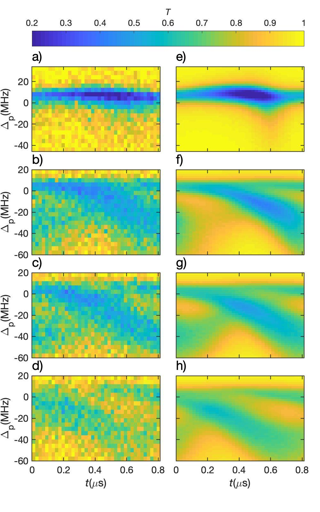


📝 Generated Summary:


╭─ Document Summary ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ ## Image Summary                                                                                                │
│                                                                                                                 │
│ The image presents a collection of 8 heatmap graphs, arranged in two columns of four rows each. The graphs are  │
│ labeled from "a)" to "h)".                                                                                      │
│                                                                                                                 │
│ ### Top Section: Color Bar                                                                                      │
│                                                                                                                 │
│ * A color bar is provided at the top, representing a correlation coefficient (τ) ranging from 0.2 to 1.         │
│ * The color bar transitions from dark blue (0.2) to yellow (1).                                                 │
│                                                                                                                 │
│ ### Graphs                                                                                                      │
│                                                                                                                 │
│ The graphs display the relationship between two variables:                                                      │
│                                                                                                                 │
│ * **x-axis:** t (μs) ranging from 0 to 0.8                                                                      │
│ * **y-axis:** Δν (MHz) with varying ranges across graphs                                                        │
│                                                                                                                 │
│ Here's a brief description of each graph:                                                                       │
│                                                                                                                 │
│ * **a)**: A relatively stable, horizontal band with a dark blue region (high correlation) around Δν = 0 MHz.    │
│ * **b)**: A scattered, random pattern with no clear trend.                                                      │
│ * **c)**: Similar to graph "b)", with a scattered pattern and no clear trend.                                   │
│ * **d)**: Another scattered pattern with a slightly more defined structure.                                     │
│ * **e)**: A diagonal, dark blue region (high correlation) with a positive slope.                                │
│ * **f)**: A diagonal, yellow-to-blue transition with a positive slope.                                          │
│ * **g)**: A curved, yellow-to-blue transition with a positive slope.                                            │
│ * **h)**: A curved, yellow-to-blue transition with a positive slope.                                            │
│                                                                                                                 │
│ ### Summary                                                                                                     │
│                                                                                                                 │
│ The image presents a set of heatmap graphs illustrating the relationship between two variables, t (μs) and Δν   │
│ (MHz), with varying patterns and correlation coefficients. The graphs can be broadly categorized into two       │
│ groups: those with relatively stable or scattered patterns (a-d) and those with diagonal or curved transitions  │
│ (e-h). The color bar at the top provides a reference f

In [16]:
# Compare original document with generated summary
index = 0  # Change this to view different examples

# Merge preview data with original images for comparison
comparison_dataset = preview.dataset.merge(pd.DataFrame(img_dataset)[["uuid", "image"]], how="left", on="uuid")

# Extract the record for display
record = comparison_dataset.iloc[index]

print("📄 Original Document Image:")
display(resize_image(record.image, BASE64_IMAGE_HEIGHT))

print("\n📝 Generated Summary:")
rich.print(Panel(record.summary, title="Document Summary", title_align="left"))

### 🆙 Scale up!

- Happy with your preview data?

- Use the `create` method to submit larger Data Designer generation jobs.


In [17]:
results = data_designer.create(config_builder, num_records=10)

[16:20:29] [INFO] 🎨 Creating Data Designer dataset


[16:20:29] [INFO] ✅ Validation passed


[16:20:29] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph


[16:20:29] [INFO] 📂 Dataset path '/home/runner/work/DataDesigner/DataDesigner/docs/notebook_source/artifacts/dataset' already exists. Dataset from this session
		     will be saved to '/home/runner/work/DataDesigner/DataDesigner/docs/notebook_source/artifacts/dataset_12-08-2025_162029' instead.


[16:20:29] [INFO] 🩺 Running health checks for models...


[16:20:29] [INFO]   |-- 👀 Checking 'meta/llama-4-scout-17b-16e-instruct' in provider named 'nvidia' for model alias 'vision'...


[16:20:30] [INFO]   |-- ✅ Passed!


[16:20:31] [INFO] ⏳ Processing batch 1 of 1


[16:20:33] [INFO] 🌱 Sampling 10 records from seed dataset


[16:20:33] [INFO]   |-- seed dataset size: 512 records


[16:20:33] [INFO]   |-- sampling strategy: ordered


[16:20:33] [INFO] 📝 Preparing llm-text column generation


[16:20:33] [INFO]   |-- column name: 'summary'


[16:20:33] [INFO]   |-- model config:
{
    "alias": "vision",
    "model": "meta/llama-4-scout-17b-16e-instruct",
    "inference_parameters": {
        "temperature": 0.6,
        "top_p": 0.95,
        "max_tokens": 2048,
        "max_parallel_requests": 4,
        "timeout": null,
        "extra_body": null
    },
    "provider": "nvidia"
}


[16:20:33] [INFO] 🐙 Processing llm-text column 'summary' with 4 concurrent workers


[16:20:54] [INFO] 📊 Model usage summary:
{
    "meta/llama-4-scout-17b-16e-instruct": {
        "token_usage": {
            "prompt_tokens": 8140,
            "completion_tokens": 4952,
            "total_tokens": 13092
        },
        "request_usage": {
            "successful_requests": 10,
            "failed_requests": 0,
            "total_requests": 10
        },
        "tokens_per_second": 559,
        "requests_per_minute": 25
    }
}


[16:20:54] [INFO] 📐 Measuring dataset column statistics:


[16:20:54] [INFO]   |-- 🌱 column: 'uuid'


[16:20:54] [INFO]   |-- 🌱 column: 'image_filename'


[16:20:54] [INFO]   |-- 🌱 column: 'base64_image'


[16:20:54] [INFO]   |-- 🌱 column: 'page'


[16:20:54] [INFO]   |-- 🌱 column: 'options'


[16:20:54] [INFO]   |-- 🌱 column: 'source'


[16:20:54] [INFO]   |-- 📝 column: 'summary'


In [18]:
# Load the generated dataset as a pandas DataFrame.
dataset = results.load_dataset()

dataset.head()

,uuid,image_filename,base64_image,page,options,source,summary
0,d50a8fed-5737-4da0-85ba-bae7b33fc8f0,images/1810.07757_2.jpg,iVBORw0KGgoAAAANSUhEUgAAAUAAAAIACAIAAAB8QiIMAA...,<NA>,['A. The variance of the data decreases from p...,arxiv_qa,## Image Summary The image presents a collecti...
1,688fccf8-0099-4aac-8a75-4ac54c311efe,data/scrapped_pdfs_split/pages_extracted/energ...,iVBORw0KGgoAAAANSUhEUgAAAYsAAAIACAIAAAD8HddaAA...,9.0,<NA>,pdf,## Document Summary The document appears to be...
2,bf2b8ed1-25a7-4d79-98f1-ca76fc4d9e5b,data/scrapped_pdfs_split/pages_extracted/energ...,iVBORw0KGgoAAAANSUhEUgAAAZgAAAIACAIAAAAwhO2xAA...,414.0,<NA>,pdf,## **14.10.3 Performance** ### **Voltage** The...
3,4a84c710-33ec-46fa-85ea-9ef75381ec6e,0fd47b51ae9248ef36669b8619b1223f268edae3e7a44a...,iVBORw0KGgoAAAANSUhEUgAAAX0AAAIACAAAAABLRuMPAA...,<NA>,<NA>,docvqa,## Document Summary The document appears to be...
4,09131c68-14e8-4b43-bd43-52158330a1d8,b335cfb9d442f8925ea41a064cb445a5395577f2345d52...,iVBORw0KGgoAAAANSUhEUgAAAY8AAAIACAAAAABf/7+rAA...,<NA>,<NA>,docvqa,**Letterhead and Date** The letter is dated **...


In [19]:
# Load the analysis results into memory.
analysis = results.load_analysis()

analysis.to_report()

──────────────────────────────────────── 🎨 Data Designer Dataset Profile ─────────────────────────────────────────

                                                                                                                   
                                                 Dataset Overview                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ number of records               ┃ number of columns               ┃ percent complete records                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10                              │ 7                               │ 100.0%                                      │
└─────────────────────────────────┴─────────────────────────────────┴─────────────────────────────────────────────┘
                                                                                                                   
                                                                                                                   
                                              🌱 Seed-Dataset Columns                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ column name                         ┃               data type ┃                            number unique values ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ uuid                                │                  string │                                     10 (100.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ image_filename                      │                  string │                                     10 (100.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ base64_image                        │                  string │                                     10 (100.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ page                                │                   float │                                       6 (60.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ options                             │                  string │                                       3 (30.0%) │
├─────────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────┤
│ source                              │                  string │                                       3 (30.0%) │
└─────────────────────────────────────┴─────────────────────────┴─────────────────────────────────────────────────┘
                                                                                                                   
                                                                                                                   
                                                📝 LLM-Text Columns                                                
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  ┃               ┃                              ┃       prompt tokens ┃       completion tokens ┃
┃ column name      ┃     data type ┃         number unique values ┃          per record ┃              per record ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ summary          │        string │                  10 (100.0%) │        38.0 +/- 0.0 │          505.0 +/- 92.4 │
└──────────────────┴───────────────┴──────────────────────

## ⏭️ Next Steps

Now that you've learned how to use visual context for image summarization in Data Designer, explore more:

- Experiment with different vision models for specific document types
- Try different prompt variations to generate specialized descriptions (e.g., technical details, key findings)
- Combine vision-based summaries with other column types for multi-modal workflows
- Apply this pattern to other vision tasks like image captioning, OCR validation, or visual question answering
